ATC to drug name:https://www.whocc.no/atc_ddd_index/, https://go.drugbank.com/atc

# Data preprocess

In [ ]:
print(sklearn.__version__)

1.2.2


In [39]:
import ast
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, jaccard_score
import joblib

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Datasets/MIMIC3.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
data=df[20000:30000]# take the first 2500 rows
select_col=['symptom','NDC','ICD9_CODE']
data = data.loc[:, select_col]
print(data.head())

                                                 symptom  \
20000  ['diaphoresis' 'pain' 'hives' 'chest pain' 'de...   
20001  ['anesthesia' 'infection' 'tired' 'trauma' 'ag...   
20002  ['shaking' 'loose stool' 'unresponsive' 'poor ...   
20003  ['pain' 'cough' 'drainage' 'wound' 'anemia' 'r...   
20004  ['respiratory distress' 'abscess' 'pleuritic c...   

                                                     NDC  \
20000  ['A06A', 'B01A', 'N02B', 'C10A', 'A01A', 'C07A...   
20001  ['A12B', 'B01A', 'A06A', 'A07A', 'B05C', 'A12C...   
20002  ['A12B', 'A07E', 'B01A', 'B05C', 'A12C', 'C03C...   
20003  ['A12B', 'A06A', 'A02B', 'B05C', 'C03C', 'N02B...   
20004  ['P01B', 'D10A', 'B01A', 'J05A', 'A06A', 'R03A...   

                                               ICD9_CODE  
20000  ['0066', '3607', '0040', '0046', '3723', '8852...  
20001  ['311', '3322', '9390', '3893', '9604', '9672'...  
20002  ['3794', '3723', '8856', '8853', '9981', '9672...  
20003  ['3611', '3615']\nCategories (2, ob



1.   SUBJECT_ID: In the context of medical data, this typically refers to a unique identifier assigned to an individual patient in a healthcare database. It's used to distinguish between different patients.
2.   HADM_ID: This stands for Hospital Admission ID. It's a unique identifier assigned to a specific hospital admission record for a patient. Each time a patient is admitted to a hospital, a new HADM_ID is generated.

3. Symptom: A symptom is a subjective indication of a disease or a change in condition that a patient reports. Symptoms are the patient's own description of what they are feeling, such as pain, dizziness, or fatigue.

4. NDC: National Drug Code (NDC) is a unique identifier for medications in the United States. It's used to identify specific drugs, including the manufacturer, the product, and the package size.

5. ICD-9 Code: This refers to the International Classification of Diseases, Ninth Revision, Clinical Modification (ICD-9-CM) code. It's used to classify diseases and a wide variety of signs, symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or disease.

6. PRO_CODE: This term is not widely recognized without specific context. It could refer to procedure codes used in medical billing or coding systems, but the exact meaning would depend on the specific database or system you are referring to.

7. NDC Length (NDC_Len): This could refer to the length of the National Drug Code (NDC). NDCs typically consist of 10 or 11 digits, but the exact length depends on the formatting convention used.

# preprocess - bag of words

In [108]:
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

data['symptom'] = data['symptom'].apply(lambda x: ast.literal_eval(x))
data['NDC'] = data['NDC'].apply(lambda x: ast.literal_eval(x))

# Using CountVectorizer for Bag of Words encoding
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X_count = count_vectorizer.fit_transform(data['symptom'].apply(lambda x: ' '.join(x)))
# Convert NDC labels into binary format using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(data['NDC'])

X_train, X_test, y_train, y_test = train_test_split(X_count, y_binary, test_size=0.35, random_state=24)

vocabulary_path = 'Symptom_vocabulary.pkl'
joblib.dump(count_vectorizer.vocabulary_, vocabulary_path)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['Symptom_vocabulary.pkl']

In [56]:
print(X_train.shape)
print(y_train[0])

(6500, 39)
[1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Using MultiLabelBinarizer is necessary when dealing with multi-label classification problems.
In a multi-label classification task, each sample (in this case, each set of symptoms) can belong to multiple classes (NDC labels), as opposed to single-label classification where each sample belongs to just one class.

# Evaluate & Save model weights

In [ ]:
joblib.dump(mlb, 'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']

In [109]:
def evaluation(y_test, predictions_binary, number=5):
  jaccard_similarity = jaccard_score(y_test, predictions_binary, average='samples')
  f1 = f1_score(y_test, predictions_binary, average='samples')
  print(f"Jaccard Similarity: {jaccard_similarity}")
  print(f"F1 Score: {f1}")

  # Print predictions compared with true labels
  for i in range(number):
      print(f"Case {i}:")
      print(f"True Labels: {mlb.inverse_transform(y_test)[i]}")
      print(f"Predicted Labels: {mlb.inverse_transform(predictions_binary)[i]}")

In [ ]:

def save_model(model, name):
  joblib.dump(model, name+'_weights.pkl')
  path='/content/'+name+'_weights.pkl'
  !mv name '/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Model Weights'

#Load model
#model = joblib.load('weights.pkl')

#  1.MultiOutputClassifier with a RandomForestClassifier base estimator
Jaccard Similarity: 0.41001764017153597
F1 Score: 0.5607176883270999

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

model=MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

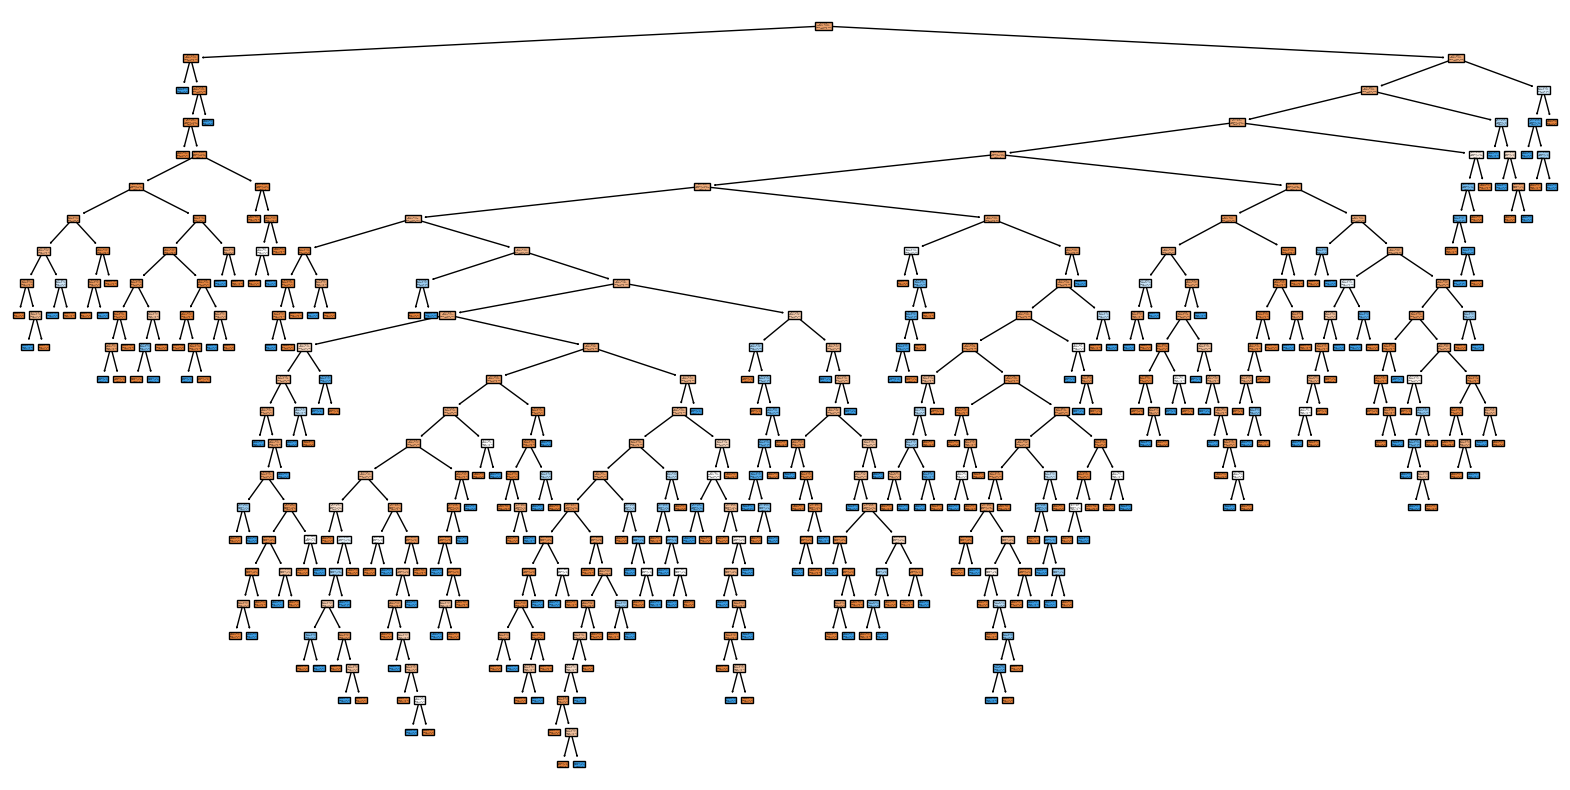

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

estimator = model.estimators_[1]
# Visualize
plt.figure(figsize=(20, 10))
plot_tree(estimator.estimators_[0], filled=True, feature_names=count_vectorizer.get_feature_names_out(), class_names=[str(i) for i in range(len(mlb.classes_))])
plt.show()
plt.savefig('RandomForestClassifier')

In [ ]:
save_model(model,"RandomForestClassifier_finalmodel_10000")

mv: cannot stat 'name': No such file or directory


In [ ]:
!mv '/content/RandomForestClassifier_finalmodel_10000_weights.pkl' '/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Model Weights'

## testing input

In [ ]:
import ast
symptoms = "respiratory distress,nausea"
symptomsArray = [item.strip() for item in symptoms.split(",")]
symptomsString = "[" + " ".join(["'" + item + "'"+"," for item in symptomsArray]) + "]"
print(symptomsString)
ast.literal_eval(symptomsString)

['respiratory distress', 'nausea',]


['respiratory distress', 'nausea']

In [ ]:
''.join(count_vectorizer.inverse_transform(X_test[1])[0])

'shortne fbacgidwkulmxpvyz.'

In [ ]:
input= "congestion, infection, ascites, ruq pain, right upper quadrant pain, warm, diarrhea, anxious"
list1 = input.split(", ")
result_str = f"[{' '.join([f'{word!r}' for word in list1])}]"

print(result_str)

['congestion' 'infection' 'ascites' 'ruq pain' 'right upper quadrant pain' 'warm' 'diarrhea' 'anxious']


## webapp

In [65]:
from flask import Flask, request, jsonify
import joblib
import ast
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

vocabulary = joblib.load('Symptom_vocabulary.pkl')
model = joblib.load('/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Model Weights/RandomForestClassifier_fine_tuned_weights.pkl')
csv_file_path ='WHO ATC-DDD 2021-12-03.csv'
mlb = joblib.load('multilabel_binarizer.pkl')
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False,vocabulary=vocabulary)

def map_atc_code_to_name(atc_codes, csv_file):
    df = pd.read_csv(csv_file)
    atc_dict = dict(zip(df['atc_code'].str.strip(), df['atc_name']))
    mapped_names = [atc_dict.get(code, 'Unknown') for code in atc_codes]
    return mapped_names

In [ ]:
x="""['oriented' 'edema' 'tenderness']"""
"""'fever', 'pressure', 'vomit'"""
"""['congestion' 'infection'
 'ascites' 'ruq pain' 'right upper quadrant pain'
 'warm' 'diarrhea' 'anxious']"""
x=ast.literal_eval(x)
X_count = count_vectorizer.fit_transform(x)
y=mlb.inverse_transform(model.predict(X_count))
print(y)
unique_y = list(set(item for sublist in y for item in sublist))
mapped_names = map_atc_code_to_name(unique_y, csv_file_path)
print(mapped_names)

eg.


1.   fever, pressure, vomit
2.   wound,thigh pain,numbness,anemia,pressure,good urine output





# 2.Multi-class Logistic Regression:
### In the logistic regression classifier, the sigmoid function is applied to the linear combination of input features and model weights to obtain the probability that the input belongs to the positive class. This output is already scaled between 0 and 1 due to the sigmoid function.
Jaccard Similarity: 0.3922128221763671
F1 Score: 0.5395880318922179

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Define the Multi-class Logistic Regression model using one-vs-rest strategy
Logistic_model = OneVsRestClassifier(LogisticRegression(random_state=24, max_iter=1250))
Logistic_model.fit(X_train, y_train)
predictions_binary = Logistic_model.predict(X_test)
evaluation(y_test, predictions_binary)

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 122 is present in all training examples.
  warnings.warn(


Jaccard Similarity: 0.3922128221763671
F1 Score: 0.5395880318922179
Case 1:
True Labels: ('A02B', 'A03F', 'A06A', 'A07A', 'A12C', 'B01A', 'C01B', 'C02A', 'C03C', 'C07A', 'C08C', 'C09A', 'D01A', 'D07A', 'J01C', 'N02A', 'N02B', 'N03A', 'N05B', 'N06A', 'R01A', 'R06A')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A12B', 'A12C', 'B01A', 'B05C', 'C07A', 'C10A', 'N02A', 'N02B')
Case 1:
True Labels: ('A02A', 'A02B', 'A06A', 'A07A', 'A10B', 'A12A', 'A12C', 'B01A', 'B05C', 'C01E', 'C02D', 'C10A', 'D04A', 'N01A', 'N02A', 'N02B', 'N03A', 'N05C')
Predicted Labels: ('A02B', 'A06A', 'A12A', 'A12B', 'A12C', 'B01A', 'B05C', 'N01A', 'N02B')
Case 1:
True Labels: ('A01A', 'A02B', 'A06A', 'A12B', 'A12C', 'B01A', 'C07A', 'C09A', 'C10A', 'N02B', 'N05B')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A12B', 'A12C', 'B01A', 'B05C', 'C07A', 'N02B')
Case 1:
True Labels: ('A02B', 'A12C', 'D04A', 'D07A', 'N01A', 'N05C')
Predicted Labels: ('A02B', 'A06A', 'A12C', 'B05C', 'N02B')
Case 1:
True Labels: ('A01A', 'A02A', 'A

In [ ]:
save_model(model,"Multi-class_Logistic_Regression")
!mv '/content/Multi-class_Logistic_Regression_weights.pkl' '/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Model Weights'

# 3.XGBClassifier
Jaccard Similarity: 0.4039256716292771
F1 Score: 0.5552176849135317

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

# Define the XGBoost classifier
XGBClassifier = XGBClassifier(objective='binary:logistic', random_state=24)
XGBClassifier.fit(X_train, y_train)
predictions_binary = XGBClassifier.predict(X_test)
evaluation(y_test, predictions_binary)

Jaccard Similarity: 0.4206452027922713
F1 Score: 0.5709309833168511
Case 0:
True Labels: ('A02B', 'A06A', 'A12B', 'B01A', 'C01B', 'C07A', 'C09A', 'C10A', 'N02B', 'N05B', 'N05C', 'R05D')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A07E', 'A12C', 'B01A', 'B03B', 'B05C', 'C05A', 'C07A', 'C09A', 'C10A', 'J01M', 'N02B', 'R01A', 'R03A')
Case 1:
True Labels: ('A02A', 'A02B', 'A06A', 'A07A', 'A12A', 'A12B', 'A12C', 'B01A', 'B02B', 'B05C', 'C01E', 'J01C', 'J01M', 'N01A', 'N02A', 'N02B', 'N05A', 'R03A', 'V03A')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A07A', 'A12A', 'A12B', 'A12C', 'B01A', 'B05C', 'C07A', 'J01D', 'N01A', 'N02A', 'N02B', 'N05B', 'N06A')
Case 2:
True Labels: ('A02B', 'A06A', 'A07A', 'A12B', 'A12C', 'C01A', 'C07A', 'C09A', 'C10A', 'J01X', 'N06A', 'S01E')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A12A', 'A12B', 'A12C', 'B01A', 'B05C', 'C07A', 'J01M', 'N02A', 'N02B')
Case 3:
True Labels: ('A02B', 'A06A', 'A12A', 'A12B', 'A12C', 'B05C', 'C09A', 'N01A', 'N02A', 'N02B', 'N05B', 'N0

In [ ]:
save_model(model,"XGBClassifier")

In [ ]:
!mv '/content/XGBClassifier_weights.pkl' '/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Model Weights'

## [Hyperparameter Tuning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

### Random Search

In [ ]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

param_dist = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__bootstrap': [True, False]
}

model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
jaccard = make_scorer(jaccard_score, average='weighted')
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring=jaccard)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)'''

### BayesSearch

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

param_space = {
    'estimator__n_estimators': Integer(50, 200),
    'estimator__max_depth': Integer(1, 50),
    'estimator__min_samples_split': Integer(2, 20),
    'estimator__min_samples_leaf': Integer(1, 10),
    'estimator__max_features': Categorical(['auto', 'sqrt', 'log2']),
    'estimator__bootstrap': Categorical([True, False])
}
jaccard = make_scorer(jaccard_score, average='weighted')
multioutput_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42))

bayes_search = BayesSearchCV(
    estimator=multioutput_rf,
    search_spaces=param_space,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    scoring=jaccard,
    verbose=5,
    random_state=42,
    optimizer_kwargs={'base_estimator': 'GP'}
)


bayes_search.fit(X_train, y_train)
best_params = bayes_search.best_params_
best_estimator = bayes_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: OrderedDict([('estimator__bootstrap', False), ('estimator__max_depth', 37), ('estimator__max_features', 'sqrt'), ('estimator__min_samples_leaf', 4), ('estimator__min_samples_split', 14), ('estimator__n_estimators', 112)])
Best Estimator: MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                       max_depth=37,
                                                       min_samples_leaf=4,
                                                       min_samples_split=14,
                                                       n_estimators=112,
                                                       random_state=42))


In [ ]:
model_tmp=best_estimator.fit(X_train, y_train,verbose=2)
predictions_binary = model_tmp.predict(X_test)
predictions = mlb.inverse_transform(predictions_binary)# Convert binary predictions back to drug ATC format
evaluation(y_test, predictions_binary)

After tuning: Jaccard Similarity: 0.42982686167028805
F1 Score: 0.5802458191241763

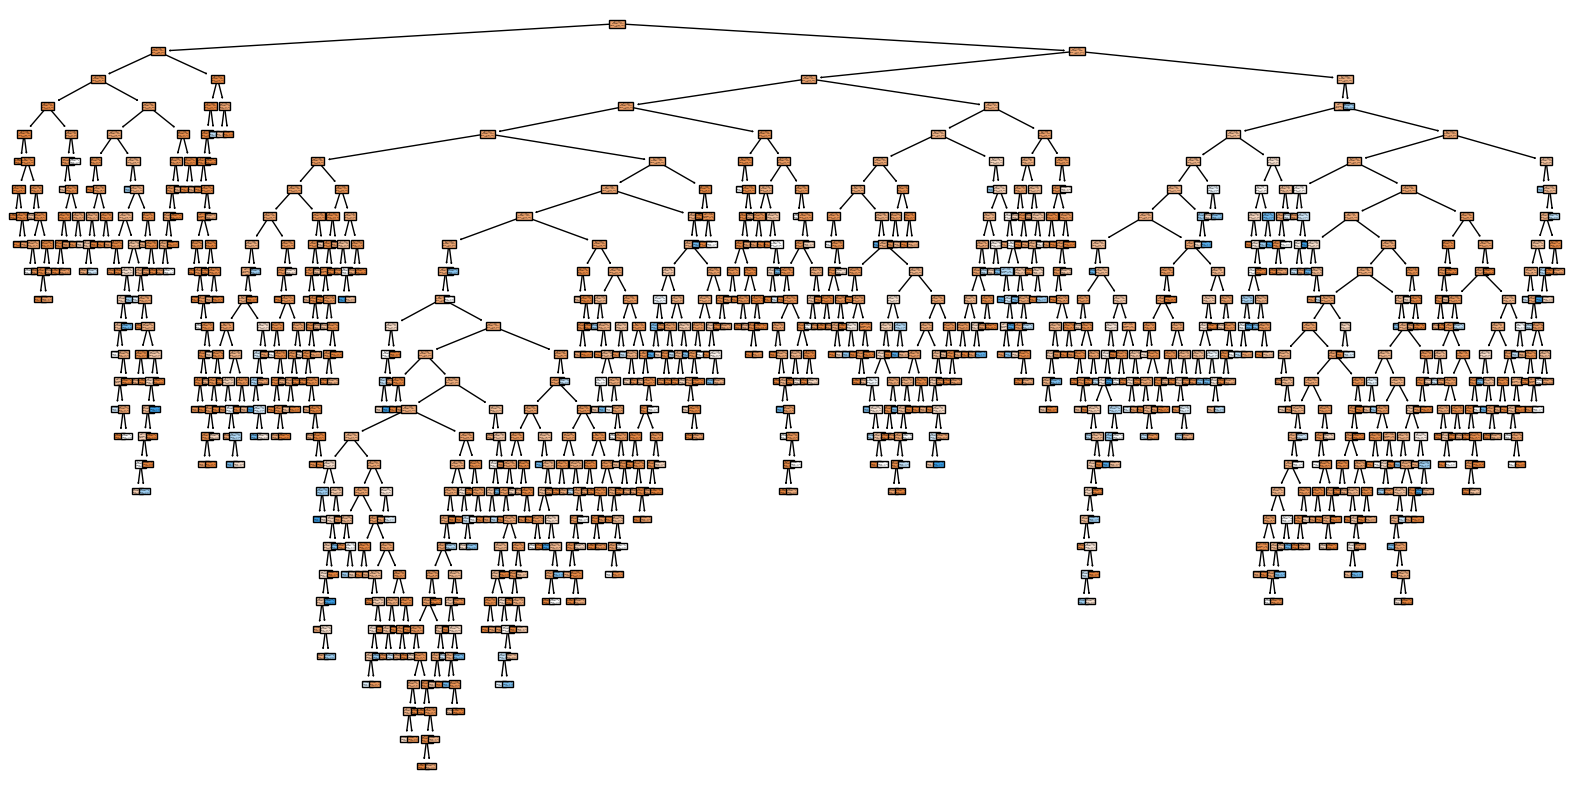

<Figure size 640x480 with 0 Axes>

In [ ]:
estimator = model_tmp.estimators_[1]
plt.figure(figsize=(20, 10))
plot_tree(estimator.estimators_[0], filled=True, feature_names=count_vectorizer.get_feature_names_out(), class_names=[str(i) for i in range(len(mlb.classes_))])
plt.show()
plt.savefig('RandomForestClassifier')

In [ ]:
save_model(model_tmp,"RandomForestClassifier_fine_tuned")

mv: cannot stat 'name': No such file or directory


In [ ]:
!mv '/content/RandomForestClassifier_fine_tuned.pkl' '/content/drive/MyDrive/McGill U2/MAIS 202/MAIS 202 Project/Model Weights'
joblib.dump(mlb, 'multilabel_binarizer.pkl')

mv: cannot stat '/content/RandomForestClassifier_fine_tuned.pkl': No such file or directory


['multilabel_binarizer.pkl']

# Parsing Drug Code

In [ ]:
test_Predicted_Labels=('A01A', 'A02B', 'A06A', 'A12B', 'A12C', 'B01A', 'B05C', 'C03C', 'C07A', 'C10A', 'N02A', 'N02B', 'N03A', 'N06A')

In [ ]:
def map_atc_code_to_name(atc_codes, csv_file):
    df = pd.read_csv(csv_file)
    atc_dict = dict(zip(df['atc_code'].str.strip(), df['atc_name']))
    mapped_names = [atc_dict.get(code, 'Unknown') for code in atc_codes]
    return mapped_names

csv_file_path ='/content/WHO ATC-DDD 2021-12-03.csv'
mapped_names = map_atc_code_to_name(test_Predicted_Labels, csv_file_path)
print("Mapped ATC Names:")
print(mapped_names)

Mapped ATC Names:
['STOMATOLOGICAL PREPARATIONS', 'DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPHAGEAL REFLUX DISEASE (GORD)', 'DRUGS FOR CONSTIPATION', 'POTASSIUM', 'OTHER MINERAL SUPPLEMENTS', 'ANTITHROMBOTIC AGENTS', 'IRRIGATING SOLUTIONS', 'HIGH-CEILING DIURETICS', 'BETA BLOCKING AGENTS', 'LIPID MODIFYING AGENTS, PLAIN', 'OPIOIDS', 'OTHER ANALGESICS AND ANTIPYRETICS', 'ANTIEPILEPTICS', 'ANTIDEPRESSANTS']


# plotting

In [175]:
predictions_binary = model.predict(X_test)
evaluation(y_test, predictions_binary)

Jaccard Similarity: 0.4441373648083261
F1 Score: 0.5931027501055793
Case 0:
True Labels: ('B01A', 'J01C')
Predicted Labels: ('J01C',)
Case 1:
True Labels: ('A02B', 'A06A', 'A07E', 'A12A', 'A12B', 'A12C', 'B01A', 'C03C', 'C05A', 'C09A', 'N02A', 'R03A')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A12B', 'A12C', 'B01A', 'B05C', 'C03C', 'C07A', 'C10A', 'J01D', 'N02A', 'N02B')
Case 2:
True Labels: ('A01A', 'A02B', 'A03F', 'A04A', 'A06A', 'A07A', 'A12A', 'A12C', 'B01A', 'B05C', 'C01C', 'C03C', 'C07A', 'D01A', 'J01C', 'N01A', 'N02B', 'N05C', 'R01A', 'R03A')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A07A', 'A12A', 'A12B', 'A12C', 'B01A', 'B05C', 'C03C', 'C07A', 'N01A', 'N02A', 'N02B', 'N05C', 'R01A', 'R03A')
Case 3:
True Labels: ('A01A', 'A02B', 'A03B', 'A03F', 'A06A', 'A07A', 'A12A', 'A12C', 'B01A', 'B05C', 'C01C', 'C01D', 'C03C', 'C07A', 'C10A', 'J01D', 'N01A', 'N02A', 'N02B', 'N06A', 'N07A')
Predicted Labels: ('A01A', 'A02B', 'A06A', 'A07A', 'A12A', 'A12B', 'A12C', 'B01A', 'B05C', 'C01C',

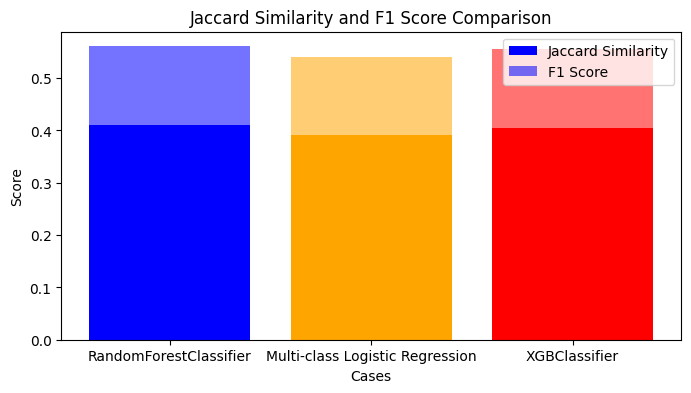

In [ ]:
import matplotlib.pyplot as plt

bar_colors = ['blue', 'orange','red']
cases=['RandomForestClassifier','Multi-class Logistic Regression','XGBClassifier']

jaccard_scores = [0.4100,0.3922,0.4039]
f1_scores = [0.5607,0.5396,0.5552]

plt.figure(figsize=(8, 4))
plt.bar(cases, jaccard_scores, label='Jaccard Similarity',color=bar_colors)
plt.bar(cases, f1_scores, label='F1 Score', alpha=0.55,color=bar_colors)
plt.xlabel('Cases')
plt.ylabel('Score')
plt.title('Jaccard Similarity and F1 Score Comparison')
plt.legend()
plt.show()

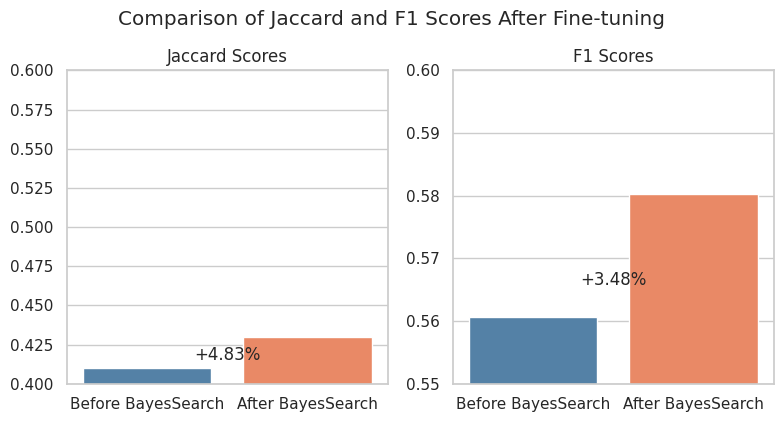

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = ['Before BayesSearch', 'After BayesSearch']
jaccard = [0.4100, 0.4298]
f1 = [0.5607, 0.5802]
jaccard_increase = ((jaccard_scores[1] - jaccard_scores[0]) / jaccard_scores[0]) * 100
f1_increase = ((f1_scores[1] - f1_scores[0]) / f1_scores[0]) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
# Jaccard
plt.subplot(1, 2, 1)
sns.barplot(x=categories, y=jaccard, palette=['steelblue', 'coral'])
plt.title('Jaccard Scores')
plt.ylim(0.4, 0.6)
plt.text(0.5, jaccard[0] + 0.005, f'+{jaccard_increase:.2f}%', ha='center')

# F1
plt.subplot(1, 2, 2)
sns.barplot(x=categories, y=f1, palette=['steelblue', 'coral'])
plt.title('F1 Scores')
plt.ylim(0.55, 0.6)
plt.text(0.5, f1_scores[0] + 0.005, f'+{f1_increase:.2f}%', ha='center')

plt.tight_layout()
plt.suptitle('Comparison of Jaccard and F1 Scores After Fine-tuning', y=1.05)
plt.show()

## Get the top 6 most common labels:
Top 6 Most Common Label:
* A06A    1959
* A02B    1957
* N02B    1885
* A12C    1821
* B01A    1796
* B05C    1757

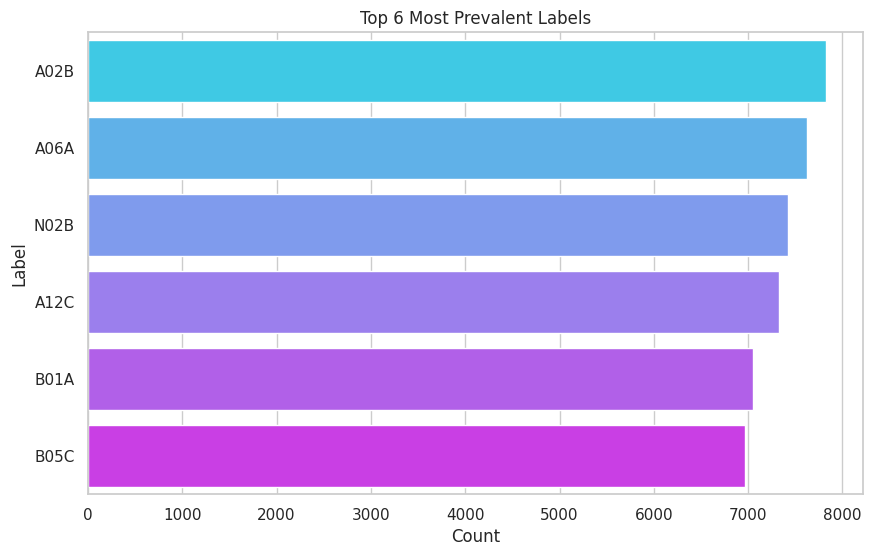

In [192]:
labels = ['A02B', 'A06A', 'N02B', 'A12C', 'B01A', 'B05C']
counts = [7825, 7621, 7421, 7322, 7048, 6967]
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=labels, palette='cool')
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Top 6 Most Prevalent Labels')
plt.show()

In [ ]:
labels = [label for sublist in mlb.inverse_transform(y_binary) for label in sublist]
top_6=pd.Series(labels).value_counts().nlargest(6)
top_6_indices = [mlb.classes_.tolist().index(label) for label in top_6.index.tolist()]
print(f"Top 6 Most Common Label:{top_6}")

In [135]:
print(len(mlb.classes_.tolist()))
true_labels = set(mlb.inverse_transform(y_test))
predicted_labels = set(predictions)

130


In [177]:
top_6_labels=['A02B','A06A','N02B','A12C','B01A','B05C']

<Figure size 500x500 with 0 Axes>

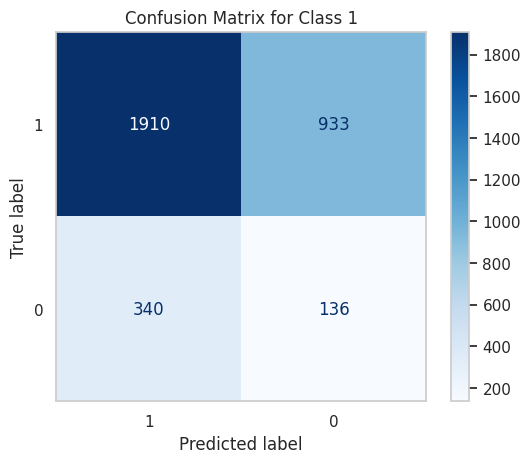

<Figure size 500x500 with 0 Axes>

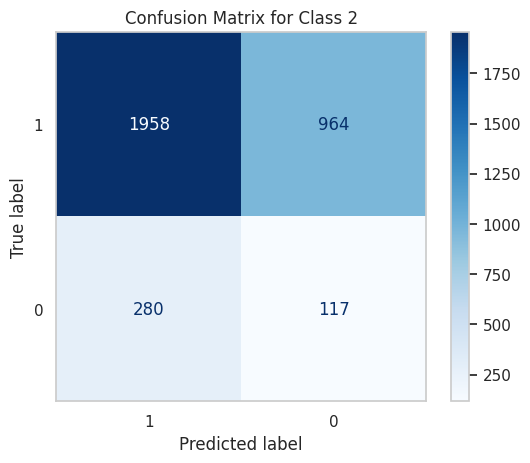

<Figure size 500x500 with 0 Axes>

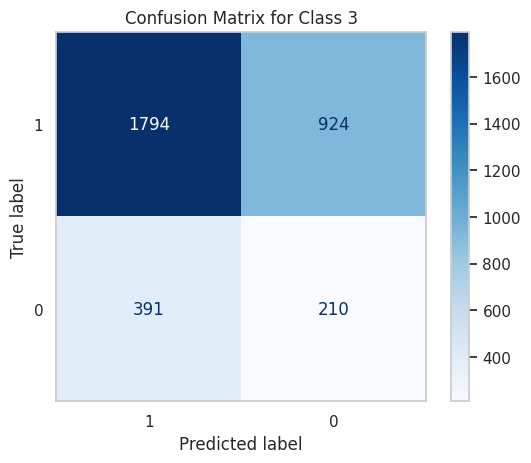

<Figure size 500x500 with 0 Axes>

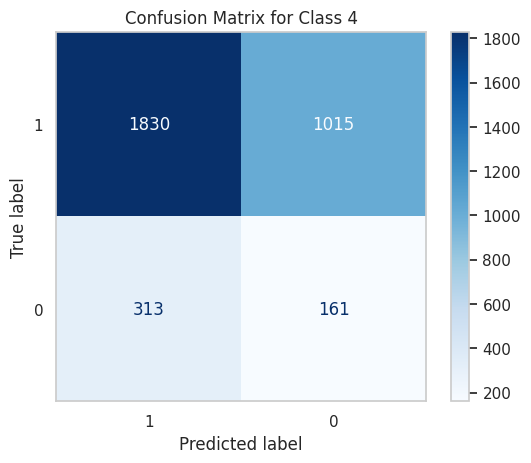

<Figure size 500x500 with 0 Axes>

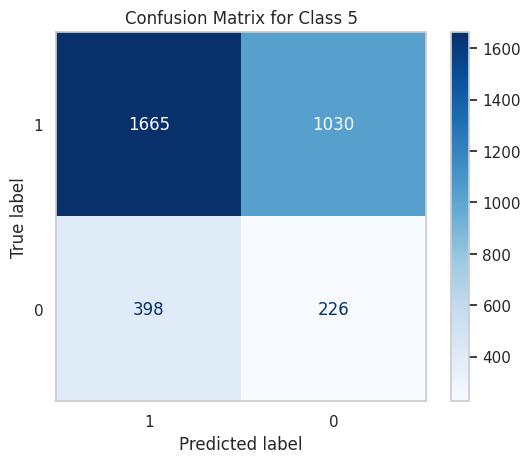

<Figure size 500x500 with 0 Axes>

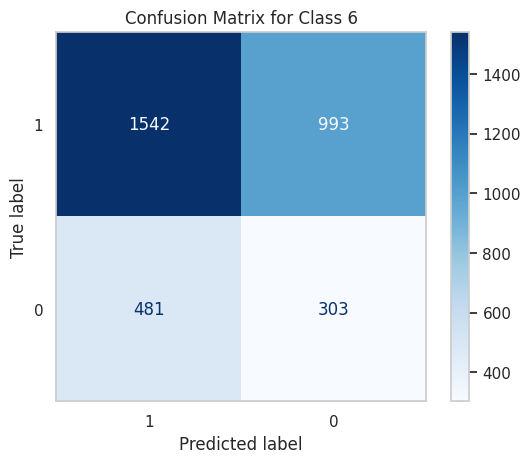

In [122]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create an empty list to store the confusion matrices
confusion_matrices = []

for label in top_6_labels:
    true_labels = set(mlb.inverse_transform(y_test))
    predicted_labels = set(predictions)

    true_labels = [label in labels for labels in true_labels]
    predicted_labels = [label in labels for labels in predicted_labels]

    max_length = max(len(true_labels), len(predicted_labels))
    true_labels += [False] * (max_length - len(true_labels))
    predicted_labels += [False] * (max_length - len(predicted_labels))
    cm = multilabel_confusion_matrix(true_labels, predicted_labels)
    confusion_matrices.append((label, cm))

# Plot the confusion matrix
for i in range(len(confusion_matrices)):
    plt.figure(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[i][1][0],
                                   display_labels=[1,0])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {i+1}')
    plt.grid(False)
    plt.show()


<ipython-input-159-ae628db87a61>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(sm)


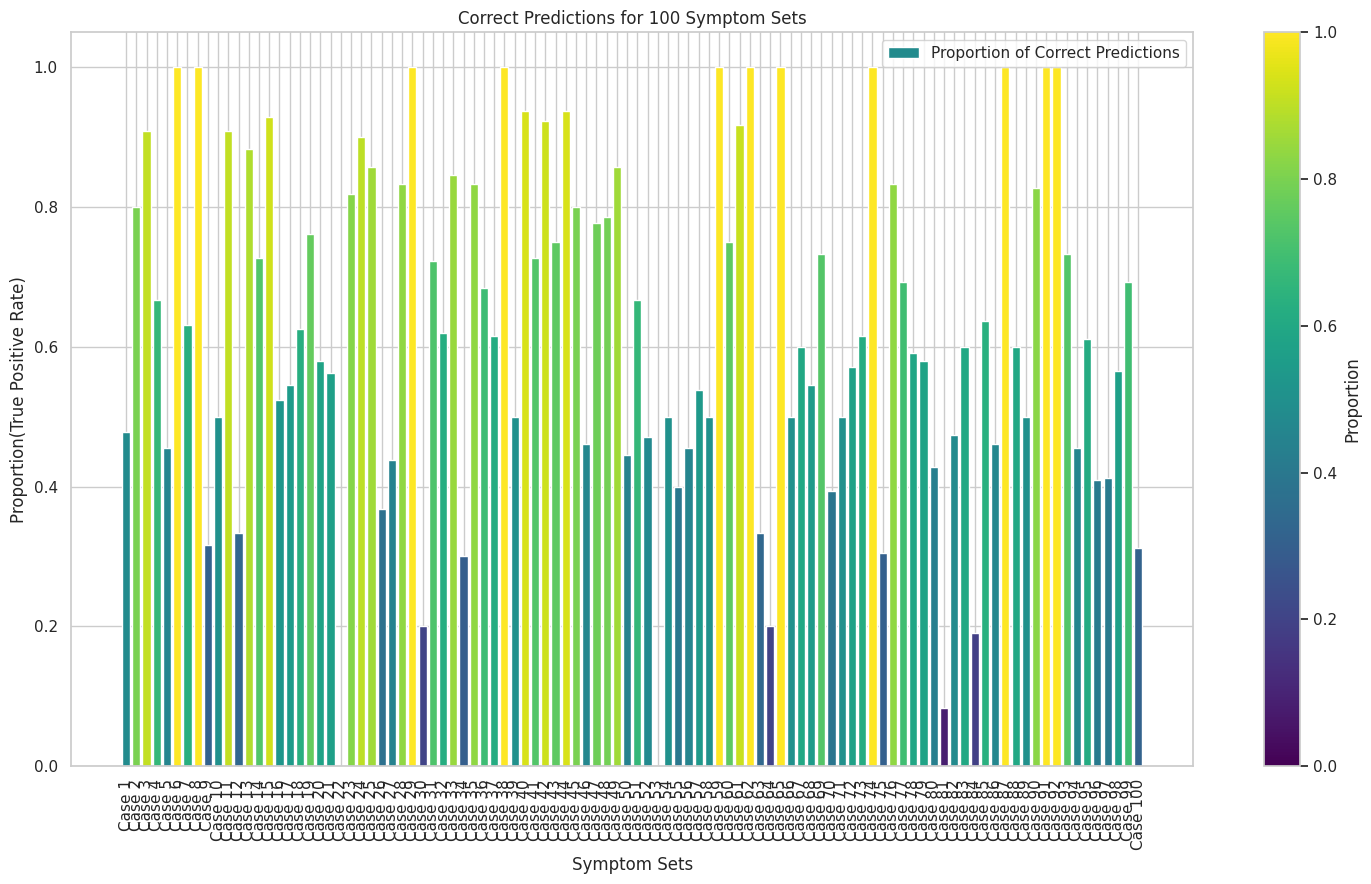

In [159]:
from matplotlib.cm import ScalarMappable

true_positives = []
false_positives = []

for true, predicted in zip(true_labels, predicted_labels):
    # Count TP
    true_pos = len(set(true).intersection(set(predicted)))
    true_positives.append(true_pos)
    # Count FP
    false_pos = len(set(predicted).difference(set(true)))
    false_positives.append(false_pos)

true_positives=true_positives[1700:1800]
false_positives=false_positives[1700:1800]
# for mismatch length issues
max_length = max(len(true_positives), len(false_positives))
true_positives += [0] * (max_length - len(true_positives))
false_positives += [0] * (max_length - len(false_positives))

# Calculate the proportion of correct predictions (True Positives)
proportions = [tp / (tp + fp) if (tp + fp) != 0 else 0 for tp, fp in zip(true_positives, false_positives)]


labels = [f"Case {i+1}" for i in range(max_length)]
colors = plt.cm.viridis(np.array(proportions))


plt.figure(figsize=(15, 9))
bars = plt.bar(labels, proportions, color=colors, label='Proportion of Correct Predictions')
sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(proportions), vmax=max(proportions)))
sm.set_array([])
colorbar = plt.colorbar(sm)
colorbar.set_label('Proportion')

plt.xticks(rotation='vertical')
plt.xlabel('Symptom Sets')
plt.ylabel('Proportion(True Positive Rate)')
plt.title('Correct Predictions for 100 Symptom Sets')
plt.legend()
plt.tight_layout()
plt.show()

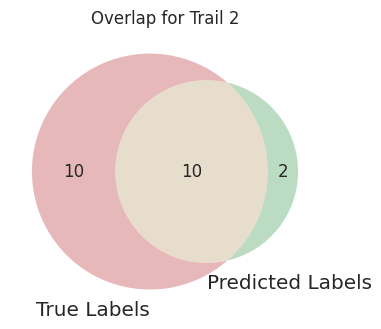

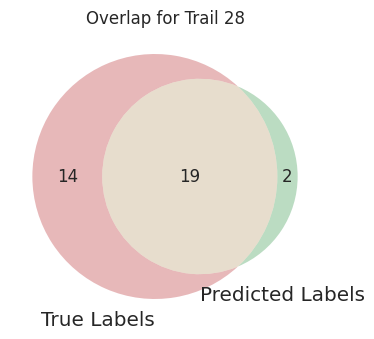

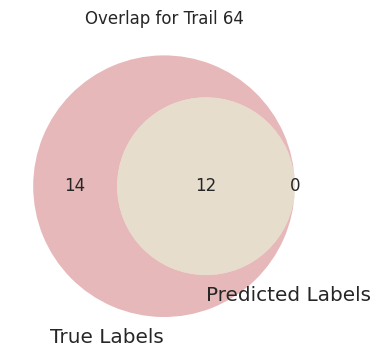

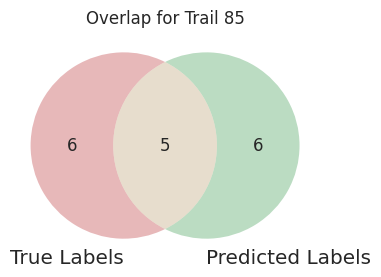

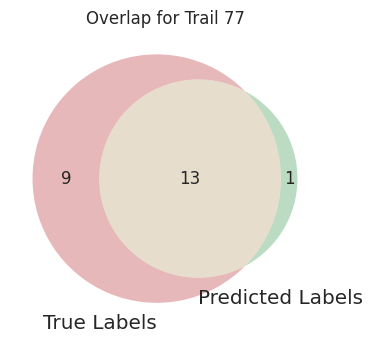

In [173]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

for i, label_index in enumerate(top_6_indices):
    true_labels = set(mlb.inverse_transform(y_test)[label_index])
    predicted_labels = set(predictions[label_index])

    plt.figure(figsize=(4, 4))
    venn2([true_labels, predicted_labels], set_labels=('True Labels', 'Predicted Labels'))
    plt.title(f'Overlap for Trail {label_index}')
    plt.show()

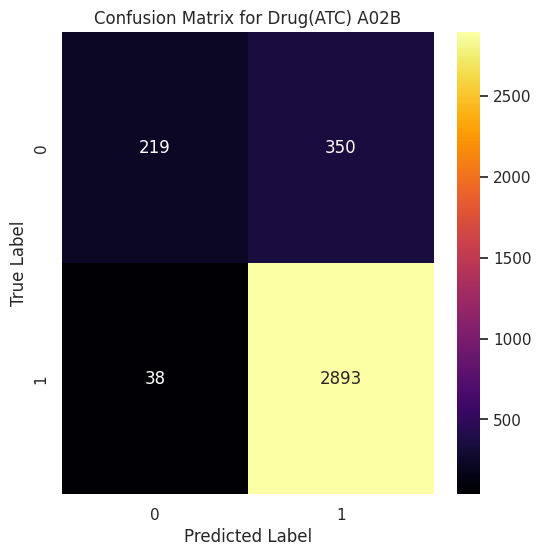

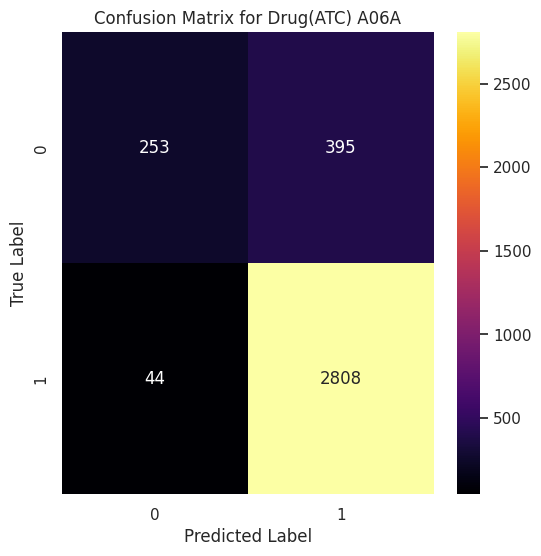

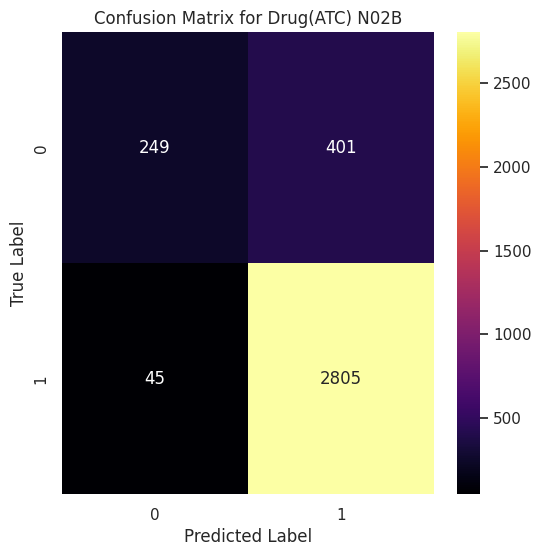

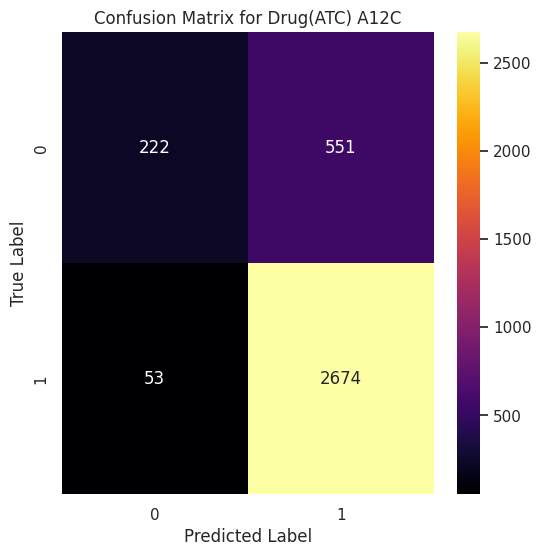

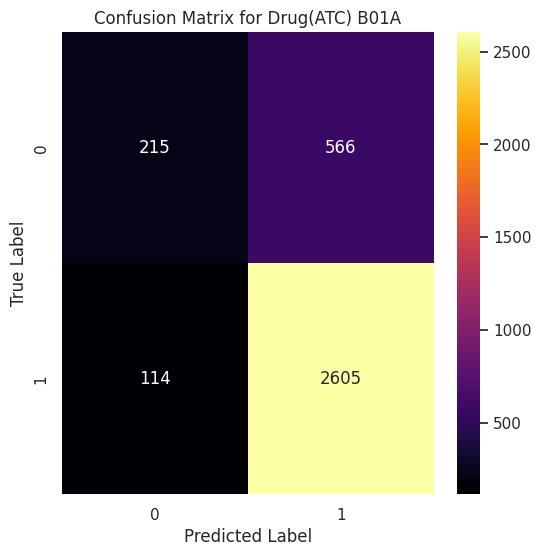

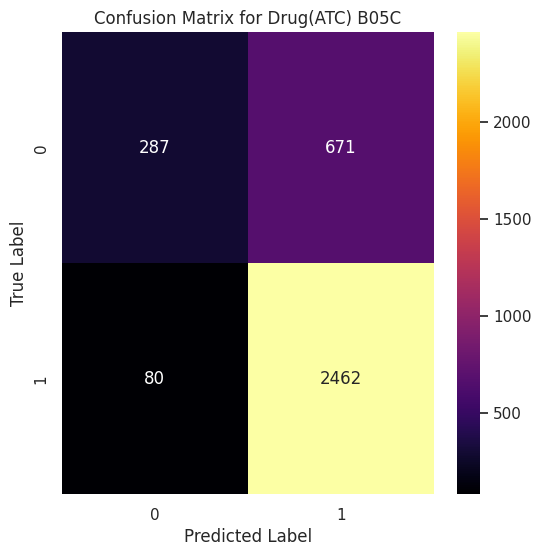

In [179]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrices = multilabel_confusion_matrix(y_test, predictions_binary)
i=0
for label_index in top_6_indices:
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrices[label_index], annot=True, fmt='d', cmap='inferno')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Drug(ATC) {top_6_labels[i]}')
    i=i+1
    plt.show()

In [ ]:
len(y_test)

875